In [1]:
import random
import json
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import argparse
from torchvision.transforms import transforms
from torchvision.models import resnet34
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# 自定义数据集
class SimpleDataset(Dataset):
    def __init__(self, data_file, transform):
        with open(data_file, 'r') as f:
            self.meta = json.load(f)
        self.transform_d = transform

    def __getitem__(self, i):
        data_path = Path(self.meta['data_path'][i])
        data = np.load(data_path, allow_pickle=True)

        data = torch.from_numpy(data).float()
        if data.shape == (8, 1280, 1280):
            data = data.unsqueeze(0)
            data = F.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        elif data.shape != (8, 224, 224):
            raise ValueError(f"Unexpected shape {data.shape} at index {i}")

        data = self.transform_d(data)
        label = int(self.meta['data_labels'][i])
        return data, label

    def __len__(self):
        return len(self.meta['data_labels'])  # 👈 关键：实现 __len__ 方法


In [3]:
# 参数设定
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--max_epoch', type=int, default=200)
parser.add_argument('--lr', type=float, default=0.0005)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--class_num', type=int, default=8)  # 🔁 修改为 8 类
option = parser.parse_known_args()[0]


In [4]:
# 数据预处理
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5] * 8, std=[0.5] * 8)
])

train_dataset = SimpleDataset('./train4.json', transform)
train_dataloader = DataLoader(train_dataset, batch_size=option.batch_size, shuffle=True, num_workers=option.num_workers)

test_dataset = SimpleDataset('./test4.json', transform)
test_dataloader = DataLoader(test_dataset, batch_size=option.batch_size, shuffle=False, num_workers=option.num_workers)



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import roi_align

# ===== DropPath 模块 =====
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.1):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0.:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        return x.div(keep_prob) * random_tensor.floor()

# ===== 可变形 RoI Pooling =====
class DeformableRoIPooling(nn.Module):
    def __init__(self, in_channels, output_size, spatial_scale, gamma=0.1):
        super().__init__()
        self.output_size = output_size
        self.spatial_scale = spatial_scale
        self.gamma = gamma
        self.offset_net = nn.Sequential(
            nn.Conv2d(in_channels, max(64, in_channels // 4), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(64, in_channels // 4), max(32, in_channels // 8), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(max(32, in_channels // 8), 2, 1)
        )

    def forward(self, features, rois):
        pooled = roi_align(features, rois, self.output_size, spatial_scale=self.spatial_scale, aligned=True)
        offsets = self.offset_net(pooled)
        return self.deformable_pooling(pooled, offsets, rois)

    def deformable_pooling(self, pooled, offsets, rois):
        N, C, H, W = pooled.shape
        device = pooled.device
        y, x = torch.meshgrid(torch.linspace(-1, 1, H, device=device),
                              torch.linspace(-1, 1, W, device=device), indexing='ij')
        base_grid = torch.stack((x, y), dim=-1).unsqueeze(0).repeat(N, 1, 1, 1)
        roi_sizes = (rois[:, 3:5] - rois[:, 1:3]).unsqueeze(-1).unsqueeze(-1).permute(0, 2, 3, 1)
        offset_grid = offsets.permute(0, 2, 3, 1) * self.gamma * roi_sizes
        deformed_grid = base_grid + offset_grid
        return F.grid_sample(pooled, deformed_grid, align_corners=True)

# ===== PR2D 模块（加入 DropPath）=====
class PR2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, deformable=False, drop_prob=0.1):
        super().__init__()
        self.deformable = deformable
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.drop_path = DropPath(drop_prob)
        if deformable:
            self.pool = DeformableRoIPooling(in_channels, (8, 8), 1.0)
        else:
            self.pool = nn.AvgPool2d(stride, stride) if stride > 1 else nn.Identity()
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride > 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.pool_channel_adjust = nn.Sequential()
        if in_channels != out_channels and deformable:
            self.pool_channel_adjust = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        conv_out = self.conv(x)
        if self.deformable:
            rois = self.create_full_roi(x)
            pool_out = self.pool(x, rois)
            pool_out = self.pool_channel_adjust(pool_out)
        else:
            pool_out = self.pool(x)
            if pool_out.shape[1] != conv_out.shape[1]:
                pool_out = nn.Conv2d(pool_out.shape[1], conv_out.shape[1], 1)(pool_out)
        pool_out = F.adaptive_avg_pool2d(pool_out, conv_out.shape[-2:])
        shortcut = self.shortcut(x)
        shortcut = F.adaptive_avg_pool2d(shortcut, conv_out.shape[-2:])
        if shortcut.shape[1] != conv_out.shape[1]:
            shortcut = nn.Conv2d(shortcut.shape[1], conv_out.shape[1], 1)(shortcut)
        return F.relu(conv_out + shortcut + self.drop_path(pool_out), inplace=True)

    def create_full_roi(self, x):
        rois = []
        for i in range(x.size(0)):
            h, w = x.shape[2:]
            rois.append([i, 0, 0, w - 1, h - 1])
        return torch.tensor(rois, dtype=torch.float, device=x.device)

# ===== ConvNeXt Block =====
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_prob=0.1):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_prob)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)
        return shortcut + self.drop_path(x)

# ===== Transformer Bridge（加权残差）=====
class SpatialTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)
        trans_out = self.transformer(x_flat)
        trans_out = trans_out.transpose(1, 2).view(B, C, H, W)
        return x + self.gamma * trans_out

# ===== 主干网络（稳定版）=====
class EnhancedFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=256, use_deformable=True):
        super().__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(8, 32, 7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.pr2d1 = PR2D(32, 64, stride=2, deformable=use_deformable)
        self.pr2d2 = PR2D(64, 128, stride=2, deformable=use_deformable)
        self.convnext = ConvNeXtBlock(128)
        self.convnext_down = nn.Conv2d(128, feature_dim, 1)
        self.transformer = SpatialTransformer(feature_dim, num_heads=4, num_layers=1)
        self.refinement = nn.Sequential(
            nn.Conv2d(feature_dim, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, feature_dim, 3, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        x = self.pre_layer(x)
        x = self.pr2d1(x)
        x = self.pr2d2(x)
        x = self.convnext(x)
        x = self.convnext_down(x)
        x = self.transformer(x)
        x = F.adaptive_avg_pool2d(x, (4, 4))
        x = self.refinement(x)
        return self.classifier(x)

In [6]:
# 初始化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = MultiSourceFeatureFusion(num_classes=option.class_num, dropout_p=0.5).to(device)
model = EnhancedFeatureExtractor(feature_dim=256, use_deformable=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=option.lr, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=option.lr, weight_decay=1e-4)
ce_loss = nn.CrossEntropyLoss().to(device)


log_train_loss, log_train_acc = [], []
log_test_loss, log_test_acc = [], []
log_best_epoch, log_best_acc = 0, 0
log_best_pred, log_test_real = [], []

In [7]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    cohen_kappa_score
)

# 初始化日志记录
log_train_loss, log_train_acc = [], []
log_test_loss, log_test_acc, log_test_f1 = [], [], []
log_test_precision, log_test_recall, log_test_aa, log_test_kappa = [], [], [], []

log_best_epoch, log_best_acc = 0, 0
log_best_pred, log_test_real = None, None

for epoch in range(1, option.max_epoch + 1):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for i, (data, label) in enumerate(train_dataloader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = ce_loss(output, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        train_correct += predicted.eq(label).sum().item()
        train_total += label.size(0)
        train_loss += loss.item()

    train_acc = 100. * train_correct / train_total
    avg_train_loss = train_loss / (i + 1)
    print(f'[Epoch:{epoch:3d}] AvgLoss: {avg_train_loss:.5f} | Acc: {train_acc:.3f}%')
    log_train_loss.append(round(avg_train_loss, 3))
    log_train_acc.append(round(train_acc, 3))

    # ===== 测试阶段 =====
    model.eval()
    test_correct, test_total, loss_test = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, label in test_dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = ce_loss(output, label)
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            test_correct += predicted.eq(label).sum().item()
            test_total += label.size(0)
            loss_test += loss.item()

    # ===== 计算指标 =====
    loss_test /= len(test_dataloader)
    test_acc = 100. * test_correct / test_total
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    aa = recall  # AA 等价于每类召回率的平均值
    kappa = cohen_kappa_score(all_labels, all_preds)

    # ===== 输出指标 =====
    print(f'\n📊 Test Metrics at Epoch {epoch}:')
    print(f'  🔹 Test Acc (OA):   {test_acc:.3f}%')
    print(f'  🔹 Test Loss:       {loss_test:.5f}')
    print(f'  🔹 Macro F1 Score:  {f1:.4f}')
    print(f'  🔹 Macro Precision: {precision:.4f}')
    print(f'  🔹 Macro Recall (AA): {recall:.4f}')
    print(f'  🔹 Kappa Score:     {kappa:.4f}')
    print('  🔹 Classification Report:\n', classification_report(all_labels, all_preds, digits=4))
    print('  🔹 Confusion Matrix:\n', confusion_matrix(all_labels, all_preds))

    # ===== 日志记录 =====
    log_test_acc.append(round(test_acc, 3))
    log_test_loss.append(round(loss_test, 5))
    log_test_f1.append(round(f1, 4))
    log_test_precision.append(round(precision, 4))
    log_test_recall.append(round(recall, 4))
    log_test_aa.append(round(aa, 4))
    log_test_kappa.append(round(kappa, 4))

    # ===== 可选：学习率调度器（如启用） =====
    # scheduler.step(loss_test)

    # ===== 保存当前表现最优模型 =====
    if test_acc >= log_best_acc and epoch > 10:
        log_best_epoch = epoch
        log_best_acc = test_acc
        log_best_pred = all_preds
        log_test_real = all_labels
        torch.save(model.state_dict(), 'DSTENet_best.pth')
        print(f'\n✅ Saved best model at epoch {epoch} with test acc {test_acc:.2f}%')

# ===== 最终提示 =====
print(
    f'\n🏁 Training complete. Best model at epoch {log_best_epoch} with test acc {log_best_acc:.2f}%. '
    f'Saved as resnet34_8class_best.pth')

[Epoch:  1] AvgLoss: 1.22787 | Acc: 43.364%

📊 Test Metrics at Epoch 1:
  🔹 Test Acc (OA):   38.489%
  🔹 Test Loss:       1.45360
  🔹 Macro F1 Score:  0.3350
  🔹 Macro Precision: 0.3565
  🔹 Macro Recall (AA): 0.3873
  🔹 Kappa Score:     0.2982
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.8500    0.5000    0.6296        34
           1     0.2344    0.4412    0.3061        34
           2     0.4928    1.0000    0.6602        34
           3     0.3590    0.4118    0.3836        34
           4     0.6875    0.2750    0.3929        40
           5     0.2286    0.4706    0.3077        34
           6     0.0000    0.0000    0.0000        34
           7     0.0000    0.0000    0.0000        34

    accuracy                         0.3849       278
   macro avg     0.3565    0.3873    0.3350       278
weighted avg     0.3637    0.3849    0.3363       278

  🔹 Confusion Matrix:
 [[17 10  1  0  5  1  0  0]
 [ 0 15  0  0  0 19  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  2] AvgLoss: 0.95275 | Acc: 49.794%

📊 Test Metrics at Epoch 2:
  🔹 Test Acc (OA):   49.640%
  🔹 Test Loss:       0.86269
  🔹 Macro F1 Score:  0.4328
  🔹 Macro Precision: 0.4916
  🔹 Macro Recall (AA): 0.4930
  🔹 Kappa Score:     0.4240
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.2647    0.4186        34
           1     0.5172    0.4412    0.4762        34
           2     0.4590    0.8235    0.5895        34
           3     0.4198    1.0000    0.5913        34
           4     0.6047    0.6500    0.6265        40
           5     0.4773    0.6176    0.5385        34
           6     0.4545    0.1471    0.2222        34
           7     0.0000    0.0000    0.0000        34

    accuracy                         0.4964       278
   macro avg     0.4916    0.4930    0.4328       278
weighted avg     0.4940    0.4964    0.4370       278

  🔹 Confusion Matrix:
 [[ 9  0  5  0 17  3  0  0]
 [ 0 15  0  1  0 18  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  3] AvgLoss: 0.83477 | Acc: 52.514%

📊 Test Metrics at Epoch 3:
  🔹 Test Acc (OA):   52.518%
  🔹 Test Loss:       0.89652
  🔹 Macro F1 Score:  0.4587
  🔹 Macro Precision: 0.4676
  🔹 Macro Recall (AA): 0.5202
  🔹 Kappa Score:     0.4567
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.0588    0.1000        34
           1     0.2727    0.0882    0.1333        34
           2     0.1579    0.0882    0.1132        34
           3     0.6970    0.6765    0.6866        34
           4     0.6250    0.7500    0.6818        40
           5     0.4821    0.7941    0.6000        34
           6     0.4783    0.9706    0.6408        34
           7     0.6944    0.7353    0.7143        34

    accuracy                         0.5252       278
   macro avg     0.4676    0.5202    0.4587       278
weighted avg     0.4710    0.5252    0.4636       278

  🔹 Confusion Matrix:
 [[ 2  0 14  0 18  0  0  0]
 [ 0  3  0  0  0 29  2  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  5] AvgLoss: 0.76401 | Acc: 54.575%

📊 Test Metrics at Epoch 5:
  🔹 Test Acc (OA):   50.000%
  🔹 Test Loss:       1.03956
  🔹 Macro F1 Score:  0.3514
  🔹 Macro Precision: 0.3727
  🔹 Macro Recall (AA): 0.5110
  🔹 Kappa Score:     0.4303
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.4658    1.0000    0.6355        34
           1     0.4928    1.0000    0.6602        34
           2     0.0000    0.0000    0.0000        34
           3     1.0000    0.0882    0.1622        34
           4     0.0000    0.0000    0.0000        40
           5     0.0000    0.0000    0.0000        34
           6     0.5000    1.0000    0.6667        34
           7     0.5231    1.0000    0.6869        34

    accuracy                         0.5000       278
   macro avg     0.3727    0.5110    0.3514       278
weighted avg     0.3647    0.5000    0.3438       278

  🔹 Confusion Matrix:
 [[34  0  0  0  0  0  0  0]
 [ 0 34  0  0  0  0  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  6] AvgLoss: 0.73427 | Acc: 54.163%

📊 Test Metrics at Epoch 6:
  🔹 Test Acc (OA):   53.237%
  🔹 Test Loss:       0.71919
  🔹 Macro F1 Score:  0.4468
  🔹 Macro Precision: 0.4717
  🔹 Macro Recall (AA): 0.5298
  🔹 Kappa Score:     0.4650
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.4828    0.4118    0.4444        34
           1     0.3333    0.0588    0.1000        34
           2     0.5000    1.0000    0.6667        34
           3     0.8182    0.2647    0.4000        34
           4     0.5652    0.6500    0.6047        40
           5     0.4921    0.9118    0.6392        34
           6     0.0000    0.0000    0.0000        34
           7     0.5818    0.9412    0.7191        34

    accuracy                         0.5324       278
   macro avg     0.4717    0.5298    0.4468       278
weighted avg     0.4737    0.5324    0.4502       278

  🔹 Confusion Matrix:
 [[14  0  0  0 20  0  0  0]
 [ 0  2  0  0  0 32  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  7] AvgLoss: 0.70187 | Acc: 55.359%

📊 Test Metrics at Epoch 7:
  🔹 Test Acc (OA):   55.755%
  🔹 Test Loss:       0.67265
  🔹 Macro F1 Score:  0.4299
  🔹 Macro Precision: 0.6234
  🔹 Macro Recall (AA): 0.5494
  🔹 Kappa Score:     0.4933
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.8235    0.4118    0.5490        34
           1     1.0000    0.0294    0.0571        34
           2     0.0000    0.0000    0.0000        34
           3     0.5075    1.0000    0.6733        34
           4     0.6491    0.9250    0.7629        40
           5     0.5075    1.0000    0.6733        34
           6     0.5000    1.0000    0.6667        34
           7     1.0000    0.0294    0.0571        34

    accuracy                         0.5576       278
   macro avg     0.6234    0.5494    0.4299       278
weighted avg     0.6240    0.5576    0.4371       278

  🔹 Confusion Matrix:
 [[14  0  0  0 20  0  0  0]
 [ 0  1  0  0  0 33  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  8] AvgLoss: 0.71750 | Acc: 56.101%

📊 Test Metrics at Epoch 8:
  🔹 Test Acc (OA):   54.317%
  🔹 Test Loss:       0.70580
  🔹 Macro F1 Score:  0.4490
  🔹 Macro Precision: 0.4260
  🔹 Macro Recall (AA): 0.5364
  🔹 Kappa Score:     0.4770
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.7000    0.4118    0.5185        34
           1     0.0000    0.0000    0.0000        34
           2     0.5714    0.3529    0.4364        34
           3     0.4925    0.9706    0.6535        34
           4     0.6296    0.8500    0.7234        40
           5     0.4928    1.0000    0.6602        34
           6     0.5217    0.7059    0.6000        34
           7     0.0000    0.0000    0.0000        34

    accuracy                         0.5432       278
   macro avg     0.4260    0.5364    0.4490       278
weighted avg     0.4304    0.5432    0.4549       278

  🔹 Confusion Matrix:
 [[14  0  0  0 20  0  0  0]
 [ 0  0  0  0  0 34  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch:  9] AvgLoss: 0.71397 | Acc: 58.038%

📊 Test Metrics at Epoch 9:
  🔹 Test Acc (OA):   57.554%
  🔹 Test Loss:       0.64057
  🔹 Macro F1 Score:  0.4959
  🔹 Macro Precision: 0.4621
  🔹 Macro Recall (AA): 0.5750
  🔹 Kappa Score:     0.5148
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.5789    0.6471    0.6111        34
           1     0.0000    0.0000    0.0000        34
           2     0.0000    0.0000    0.0000        34
           3     0.8000    0.5882    0.6780        34
           4     0.6667    0.6000    0.6316        40
           5     0.5000    1.0000    0.6667        34
           6     0.4769    0.9118    0.6263        34
           7     0.6744    0.8529    0.7532        34

    accuracy                         0.5755       278
   macro avg     0.4621    0.5750    0.4959       278
weighted avg     0.4665    0.5755    0.4988       278

  🔹 Confusion Matrix:
 [[22  0  0  0 12  0  0  0]
 [ 0  0  0  0  0 34  0  0]


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 10] AvgLoss: 0.69035 | Acc: 56.307%

📊 Test Metrics at Epoch 10:
  🔹 Test Acc (OA):   53.957%
  🔹 Test Loss:       0.67534
  🔹 Macro F1 Score:  0.4442
  🔹 Macro Precision: 0.4377
  🔹 Macro Recall (AA): 0.5454
  🔹 Kappa Score:     0.4746
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.4821    0.7941    0.6000        34
           1     0.5000    1.0000    0.6667        34
           2     0.0000    0.0000    0.0000        34
           3     0.5962    0.9118    0.7209        34
           4     0.6111    0.2750    0.3793        40
           5     0.0000    0.0000    0.0000        34
           6     0.5000    1.0000    0.6667        34
           7     0.8125    0.3824    0.5200        34

    accuracy                         0.5396       278
   macro avg     0.4377    0.5454    0.4442       278
weighted avg     0.4415    0.5396    0.4428       278

  🔹 Confusion Matrix:
 [[27  0  0  0  7  0  0  0]
 [ 0 34  0  0  0  0  0  0]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 11] AvgLoss: 0.67423 | Acc: 58.120%

📊 Test Metrics at Epoch 11:
  🔹 Test Acc (OA):   64.388%
  🔹 Test Loss:       0.62642
  🔹 Macro F1 Score:  0.5785
  🔹 Macro Precision: 0.7380
  🔹 Macro Recall (AA): 0.6360
  🔹 Kappa Score:     0.5921
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.4118    0.5833        34
           1     0.6667    0.1176    0.2000        34
           2     1.0000    0.0882    0.1622        34
           3     0.7812    0.7353    0.7576        34
           4     0.6667    1.0000    0.8000        40
           5     0.5161    0.9412    0.6667        34
           6     0.5231    1.0000    0.6869        34
           7     0.7500    0.7941    0.7714        34

    accuracy                         0.6439       278
   macro avg     0.7380    0.6360    0.5785       278
weighted avg     0.7364    0.6439    0.5833       278

  🔹 Confusion Matrix:
 [[14  0  0  0 20  0  0  0]
 [ 0  4  0  0  0 30  0  0]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 15] AvgLoss: 0.64745 | Acc: 61.212%

📊 Test Metrics at Epoch 15:
  🔹 Test Acc (OA):   58.993%
  🔹 Test Loss:       0.67761
  🔹 Macro F1 Score:  0.5176
  🔹 Macro Precision: 0.6948
  🔹 Macro Recall (AA): 0.5886
  🔹 Kappa Score:     0.5313
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.6216    0.6765    0.6479        34
           1     0.5246    0.9412    0.6737        34
           2     0.5075    1.0000    0.6733        34
           3     0.9091    0.2941    0.4444        34
           4     0.7027    0.6500    0.6753        40
           5     0.7143    0.1471    0.2439        34
           6     1.0000    0.0294    0.0571        34
           7     0.5789    0.9706    0.7253        34

    accuracy                         0.5899       278
   macro avg     0.6948    0.5886    0.5176       278
weighted avg     0.6950    0.5899    0.5210       278

  🔹 Confusion Matrix:
 [[23  0  0  0 11  0  0  0]
 [ 0 32  0  0  0  2  0  0]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 20] AvgLoss: 0.61626 | Acc: 64.509%

📊 Test Metrics at Epoch 20:
  🔹 Test Acc (OA):   58.273%
  🔹 Test Loss:       0.73626
  🔹 Macro F1 Score:  0.5010
  🔹 Macro Precision: 0.5900
  🔹 Macro Recall (AA): 0.5879
  🔹 Kappa Score:     0.5237
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.5625    0.7941    0.6585        34
           1     0.0000    0.0000    0.0000        34
           2     0.5075    1.0000    0.6733        34
           3     0.7812    0.7353    0.7576        34
           4     0.6667    0.3500    0.4590        40
           5     0.4722    1.0000    0.6415        34
           6     1.0000    0.0294    0.0571        34
           7     0.7297    0.7941    0.7606        34

    accuracy                         0.5827       278
   macro avg     0.5900    0.5879    0.5010       278
weighted avg     0.5916    0.5827    0.5000       278

  🔹 Confusion Matrix:
 [[27  0  0  0  7  0  0  0]
 [ 0  0  0  0  0 34  0  0]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 21] AvgLoss: 0.61556 | Acc: 63.809%

📊 Test Metrics at Epoch 21:
  🔹 Test Acc (OA):   62.230%
  🔹 Test Loss:       0.60443
  🔹 Macro F1 Score:  0.6075
  🔹 Macro Precision: 0.6272
  🔹 Macro Recall (AA): 0.6206
  🔹 Kappa Score:     0.5682
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.6667    0.7059    0.6857        34
           1     0.4490    0.6471    0.5301        34
           2     0.5532    0.7647    0.6420        34
           3     0.9130    0.6176    0.7368        34
           4     0.7368    0.7000    0.7179        40
           5     0.3684    0.2059    0.2642        34
           6     0.6190    0.3824    0.4727        34
           7     0.7111    0.9412    0.8101        34

    accuracy                         0.6223       278
   macro avg     0.6272    0.6206    0.6075       278
weighted avg     0.6295    0.6223    0.6098       278

  🔹 Confusion Matrix:
 [[24  0  0  0 10  0  0  0]
 [ 0 22  0  0  0 12  0  0]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

[Epoch: 23] AvgLoss: 0.60525 | Acc: 65.416%

📊 Test Metrics at Epoch 23:
  🔹 Test Acc (OA):   56.475%
  🔹 Test Loss:       0.76592
  🔹 Macro F1 Score:  0.5244
  🔹 Macro Precision: 0.6213
  🔹 Macro Recall (AA): 0.5585
  🔹 Kappa Score:     0.5019
  🔹 Classification Report:
               precision    recall  f1-score   support

           0     0.8261    0.5588    0.6667        34
           1     0.4634    0.5588    0.5067        34
           2     0.5000    0.7353    0.5952        34
           3     1.0000    0.1176    0.2105        34
           4     0.6939    0.8500    0.7640        40
           5     0.4643    0.3824    0.4194        34
           6     0.5000    0.2647    0.3462        34
           7     0.5231    1.0000    0.6869        34

    accuracy                         0.5647       278
   macro avg     0.6213    0.5585    0.5244       278
weighted avg     0.6229    0.5647    0.5296       278

  🔹 Confusion Matrix:
 [[19  0  0  0 15  0  0  0]
 [ 0 19  0  0  0 15  0  0]

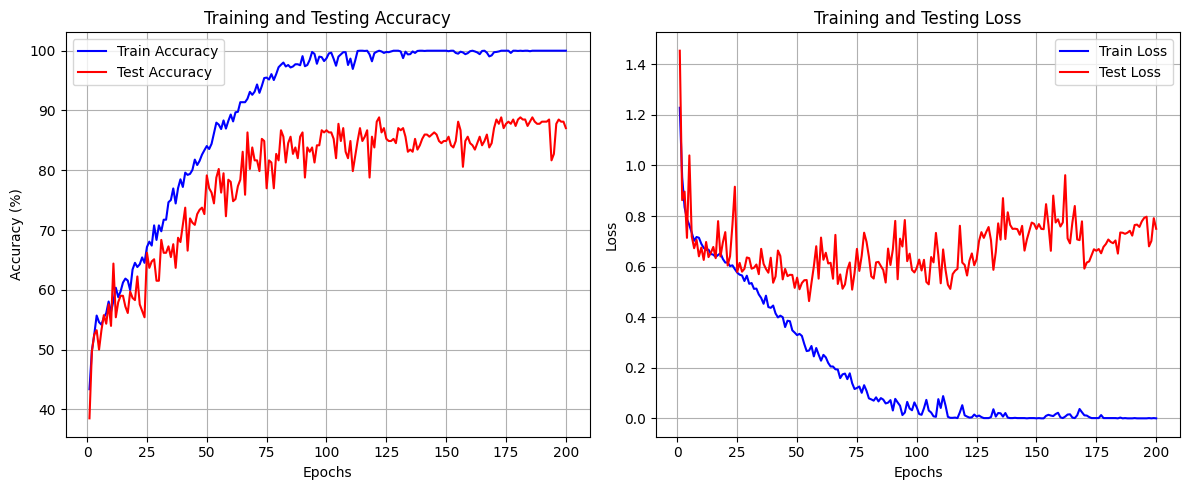

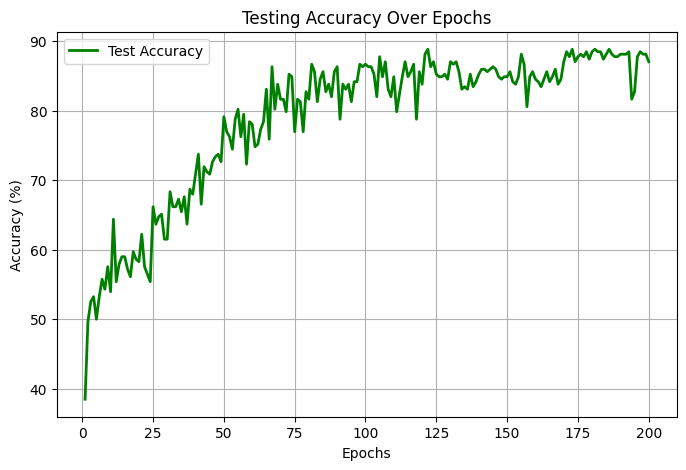

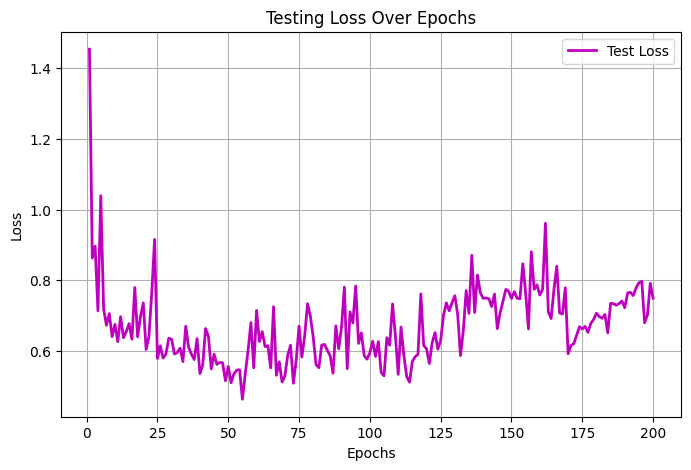

In [8]:
# 📈 绘图
time_cor = range(1, len(log_test_acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_cor, log_train_acc, 'b-', label='Train Accuracy')
plt.plot(time_cor, log_test_acc, 'r-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time_cor, log_train_loss, 'b-', label='Train Loss')
plt.plot(time_cor, log_test_loss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(time_cor, log_test_acc, 'g-', linewidth=2, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(time_cor, log_test_loss, 'm-', linewidth=2, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(log_test_acc)

[38.489, 49.64, 52.518, 53.237, 50.0, 53.237, 55.755, 54.317, 57.554, 53.957, 64.388, 55.396, 57.914, 58.993, 58.993, 57.194, 56.115, 59.712, 58.633, 58.273, 62.23, 57.554, 56.475, 55.396, 66.187, 63.669, 64.748, 65.108, 61.511, 61.511, 68.345, 66.187, 66.187, 67.266, 65.468, 67.626, 63.669, 68.705, 67.986, 70.863, 73.741, 66.547, 71.942, 71.223, 70.863, 72.662, 73.381, 73.741, 72.662, 79.137, 76.978, 76.259, 74.46, 78.777, 80.216, 76.259, 79.496, 72.302, 78.417, 78.058, 74.82, 75.18, 77.338, 78.417, 83.094, 75.899, 86.331, 80.216, 83.813, 81.655, 81.655, 79.856, 85.252, 84.892, 76.978, 81.655, 81.295, 76.978, 82.734, 81.655, 86.691, 85.612, 81.295, 84.532, 85.612, 82.734, 83.813, 82.014, 85.612, 86.331, 78.777, 83.813, 83.094, 83.813, 81.295, 84.173, 84.173, 86.691, 86.331, 86.691, 86.331, 86.331, 85.252, 82.014, 87.77, 84.892, 87.05, 83.094, 82.014, 84.892, 79.856, 82.374, 84.892, 87.05, 84.892, 85.612, 86.691, 78.777, 85.612, 83.813, 88.129, 88.849, 86.331, 87.05, 85.252, 84.892, 84

In [10]:
last_50 = log_test_acc[-50:]  # 切片获取最后50个元素
avg_last_50 = sum(last_50) / len(last_50)  # 计算平均值

print("最后50个测试准确率的平均值:", avg_last_50)

最后50个测试准确率的平均值: 86.56108


In [11]:
print(log_test_loss)

[1.4536, 0.86269, 0.89652, 0.71361, 1.03956, 0.71919, 0.67265, 0.7058, 0.64057, 0.67534, 0.62642, 0.69715, 0.63759, 0.65497, 0.67761, 0.63343, 0.77977, 0.64008, 0.69599, 0.73626, 0.60443, 0.64104, 0.76592, 0.91582, 0.57889, 0.6147, 0.57994, 0.59134, 0.63612, 0.63327, 0.59165, 0.59561, 0.60824, 0.57011, 0.67016, 0.61113, 0.59081, 0.57586, 0.63503, 0.53616, 0.56091, 0.66359, 0.6418, 0.54947, 0.59091, 0.56231, 0.56751, 0.56705, 0.51588, 0.5563, 0.51037, 0.53501, 0.54612, 0.54698, 0.46366, 0.53504, 0.60099, 0.68055, 0.55242, 0.71478, 0.62694, 0.65478, 0.61237, 0.61506, 0.552, 0.72535, 0.53141, 0.56918, 0.51253, 0.52934, 0.58841, 0.61633, 0.50889, 0.57453, 0.67003, 0.58295, 0.64361, 0.73408, 0.69826, 0.63928, 0.56134, 0.55271, 0.61662, 0.61865, 0.60199, 0.58647, 0.53706, 0.67124, 0.60645, 0.66764, 0.78067, 0.54996, 0.71053, 0.67928, 0.78412, 0.62146, 0.65112, 0.58681, 0.57686, 0.59494, 0.6278, 0.58452, 0.62671, 0.53936, 0.52981, 0.63788, 0.61671, 0.73316, 0.64542, 0.534, 0.66785, 0.58741, 0

In [12]:
print(log_train_acc)

[43.364, 49.794, 52.514, 55.688, 54.575, 54.163, 55.359, 56.101, 58.038, 56.307, 58.12, 60.346, 58.78, 59.728, 61.212, 61.871, 61.542, 59.934, 63.397, 64.509, 63.809, 64.262, 65.416, 64.509, 67.148, 68.054, 67.395, 70.775, 68.343, 70.775, 69.786, 71.723, 71.723, 74.65, 75.021, 76.958, 74.444, 76.999, 78.483, 77.205, 79.596, 79.225, 79.39, 80.049, 81.781, 80.874, 81.575, 82.605, 83.347, 84.048, 83.553, 84.419, 86.191, 87.964, 87.634, 86.892, 88.335, 86.974, 88.252, 89.324, 88.17, 89.695, 89.777, 91.385, 91.385, 91.385, 91.962, 93.116, 92.622, 93.157, 94.353, 92.951, 94.106, 95.425, 95.507, 95.177, 96.084, 95.095, 96.084, 97.238, 97.65, 98.021, 97.362, 97.609, 97.197, 97.362, 97.733, 97.733, 97.568, 99.093, 97.403, 97.609, 98.475, 99.794, 99.464, 97.815, 99.011, 98.928, 98.269, 98.722, 99.547, 99.67, 98.64, 97.486, 99.011, 99.382, 99.753, 99.753, 97.609, 98.681, 96.95, 98.351, 99.959, 100.0, 100.0, 99.959, 100.0, 99.382, 98.228, 99.588, 99.835, 100.0, 99.876, 99.629, 99.794, 99.753, 99.8

In [13]:
print(log_train_loss)

[1.228, 0.953, 0.835, 0.788, 0.764, 0.734, 0.702, 0.717, 0.714, 0.69, 0.674, 0.666, 0.667, 0.65, 0.647, 0.638, 0.646, 0.653, 0.63, 0.616, 0.616, 0.602, 0.605, 0.59, 0.576, 0.568, 0.565, 0.543, 0.564, 0.532, 0.535, 0.512, 0.513, 0.49, 0.476, 0.453, 0.485, 0.44, 0.437, 0.446, 0.415, 0.399, 0.406, 0.4, 0.361, 0.386, 0.384, 0.348, 0.339, 0.329, 0.334, 0.326, 0.294, 0.266, 0.268, 0.286, 0.245, 0.278, 0.252, 0.228, 0.251, 0.241, 0.219, 0.205, 0.205, 0.194, 0.193, 0.159, 0.174, 0.177, 0.155, 0.178, 0.139, 0.116, 0.12, 0.126, 0.101, 0.131, 0.109, 0.079, 0.075, 0.07, 0.083, 0.067, 0.08, 0.074, 0.059, 0.062, 0.072, 0.031, 0.077, 0.063, 0.05, 0.013, 0.023, 0.065, 0.039, 0.032, 0.063, 0.043, 0.017, 0.014, 0.04, 0.073, 0.031, 0.023, 0.008, 0.006, 0.076, 0.041, 0.088, 0.051, 0.006, 0.002, 0.002, 0.003, 0.001, 0.024, 0.052, 0.012, 0.007, 0.003, 0.004, 0.015, 0.007, 0.011, 0.005, 0.001, 0.001, 0.001, 0.005, 0.036, 0.007, 0.021, 0.02, 0.007, 0.021, 0.003, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001

In [14]:
print("\n📈 每轮测试指标列表（按 epoch 顺序）：")
print("Test Accuracy (%):", log_test_acc)
print("Test Loss:", log_test_loss)
print("Macro F1 Score:", log_test_f1)
print("Macro Precision:", log_test_precision)
print("Macro Recall (AA):", log_test_recall)
print("AA:", log_test_aa)
print("Kappa Score:", log_test_kappa)



📈 每轮测试指标列表（按 epoch 顺序）：
Test Accuracy (%): [38.489, 49.64, 52.518, 53.237, 50.0, 53.237, 55.755, 54.317, 57.554, 53.957, 64.388, 55.396, 57.914, 58.993, 58.993, 57.194, 56.115, 59.712, 58.633, 58.273, 62.23, 57.554, 56.475, 55.396, 66.187, 63.669, 64.748, 65.108, 61.511, 61.511, 68.345, 66.187, 66.187, 67.266, 65.468, 67.626, 63.669, 68.705, 67.986, 70.863, 73.741, 66.547, 71.942, 71.223, 70.863, 72.662, 73.381, 73.741, 72.662, 79.137, 76.978, 76.259, 74.46, 78.777, 80.216, 76.259, 79.496, 72.302, 78.417, 78.058, 74.82, 75.18, 77.338, 78.417, 83.094, 75.899, 86.331, 80.216, 83.813, 81.655, 81.655, 79.856, 85.252, 84.892, 76.978, 81.655, 81.295, 76.978, 82.734, 81.655, 86.691, 85.612, 81.295, 84.532, 85.612, 82.734, 83.813, 82.014, 85.612, 86.331, 78.777, 83.813, 83.094, 83.813, 81.295, 84.173, 84.173, 86.691, 86.331, 86.691, 86.331, 86.331, 85.252, 82.014, 87.77, 84.892, 87.05, 83.094, 82.014, 84.892, 79.856, 82.374, 84.892, 87.05, 84.892, 85.612, 86.691, 78.777, 85.612, 83.813, 88.12

In [15]:
# ===== 计算后50轮平均值 =====
last_n = 50
print(f"\n📊 后 {last_n} 轮指标平均值：")
print("Avg Test Accuracy (%):", round(sum(log_test_acc[-last_n:]) / min(last_n, len(log_test_acc)), 4))
print("Avg Test Loss:", round(sum(log_test_loss[-last_n:]) / min(last_n, len(log_test_loss)), 5))
print("Avg Macro F1 Score:", round(sum(log_test_f1[-last_n:]) / min(last_n, len(log_test_f1)), 4))
print("Avg Macro Precision:", round(sum(log_test_precision[-last_n:]) / min(last_n, len(log_test_precision)), 4))
print("Avg Macro Recall (AA):", round(sum(log_test_recall[-last_n:]) / min(last_n, len(log_test_recall)), 4))
print("Avg AA:", round(sum(log_test_aa[-last_n:]) / min(last_n, len(log_test_aa)), 4))
print("Avg Kappa Score:", round(sum(log_test_kappa[-last_n:]) / min(last_n, len(log_test_kappa)), 4))



📊 后 50 轮指标平均值：
Avg Test Accuracy (%): 86.5611
Avg Test Loss: 0.7321
Avg Macro F1 Score: 0.8651
Avg Macro Precision: 0.8695
Avg Macro Recall (AA): 0.8656
Avg AA: 0.8656
Avg Kappa Score: 0.8463


In [1]:
# ===== 计算后50轮平均值 =====
last_n = 20
print(f"\n📊 后 {last_n} 轮指标平均值：")
print("Avg Test Accuracy (%):", round(sum(log_test_acc[-last_n:]) / min(last_n, len(log_test_acc)), 4))
print("Avg Test Loss:", round(sum(log_test_loss[-last_n:]) / min(last_n, len(log_test_loss)), 5))
print("Avg Macro F1 Score:", round(sum(log_test_f1[-last_n:]) / min(last_n, len(log_test_f1)), 4))
print("Avg Macro Precision:", round(sum(log_test_precision[-last_n:]) / min(last_n, len(log_test_precision)), 4))
print("Avg Macro Recall (AA):", round(sum(log_test_recall[-last_n:]) / min(last_n, len(log_test_recall)), 4))
print("Avg AA:", round(sum(log_test_aa[-last_n:]) / min(last_n, len(log_test_aa)), 4))
print("Avg Kappa Score:", round(sum(log_test_kappa[-last_n:]) / min(last_n, len(log_test_kappa)), 4))



📊 后 20 轮指标平均值：


NameError: name 'log_test_acc' is not defined